<a href="https://colab.research.google.com/github/HitoshiSatoo/Text_classifier/blob/main/Training_a_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Este notebook tem a finalidade de estudar o treinamento de classificação de texto

##  Transformers as Feature Extractors

###  Using pretrained models

In [1]:
# Instalar a biblioteca transformers
!pip install transformers

In [2]:
# Importar AutoModel
from transformers import AutoModel

# Importar torch
import torch

# Importar AutoTokenizer
from transformers import AutoTokenizer

In [3]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Extracting the last hidden states

In [4]:
import torch.nn.functional as F

In [5]:
text = "this is a test"

In [6]:
tokenized_text = list(text)

In [7]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'a': 1, 'e': 2, 'h': 3, 'i': 4, 's': 5, 't': 6}


In [8]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[6, 3, 4, 5, 0, 4, 5, 0, 1, 0, 6, 2, 5, 6]


In [9]:
input_ids = torch.tensor(input_ids)

In [10]:
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [11]:
inputs = {k:v.to(device) for k,v in inputs.items()}

* `inputs` contém os dados processados para o modelo (como tokens e máscaras de atenção).
* `device` define se o modelo será executado na GPU `(cuda)` ou CPU `(cpu)`.
* Essa linha garante que todos os tensores dentro de `inputs` sejam movidos para a mesma unidade de processamento (GPU ou CPU).

In [12]:
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


* `torch.no_grad()` desativa o cálculo de gradientes, economizando memória e acelerando a inferência.

* `model(**inputs)` passa os inputs para o modelo e gera outputs (normalmente tensores com embeddings ou logits para classificação).

* Mostra a saída do modelo, que pode ser um dicionário contendo logits, embeddings ou scores de classificação.

In [13]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

🔹 O que last_hidden_state representa?

* `last_hidden_state` contém as representações dos tokens do texto de entrada na última camada do modelo.
* Cada token recebe um vetor de embeddings, que pode ser usado para diversas tarefas (como classificação de texto ou análise de sentimentos).

Ou seja, 1 frases, cada uma com 6 tokens, e cada token representado por um vetor de 768 dimensões.

In [14]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [15]:
def extract_hidden_states(batch):
    # Filtrar inputs válidos e movê-los para GPU/CPU
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    # Inferência sem cálculo de gradiente
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Retornar apenas o vetor do token [CLS]
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [16]:
# Instalar a biblioteca datasets
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [17]:
 from datasets import load_dataset
 emotions = load_dataset("emotion")

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [19]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [22]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [23]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

In [25]:
import numpy as np

In [26]:
# Dividir os dados de treino e validação
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

###  Visualizing the training set

In [27]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [28]:
X_scaled = MinMaxScaler().fit_transform(X_train)

 O que faz?

* Usa `MinMaxScaler()` para normalizar os dados no intervalo [0,1], o que melhora o desempenho do UMAP.

* `fit_transform(X_train)`: Ajusta e transforma os dados de treino.


In [29]:
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 O que faz?

* Inicializa o UMAP para projetar `X_scaled` em um espaço de 2 dimensões `(n_components=2)`.

* Usa "cosine" como métrica de distância (ideal para dados textuais e embeddings).
* `fit(X_scaled)`: Treina o UMAP com os dados de entrada.

In [30]:
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

O que faz?

`mapper.embedding_` contém as novas coordenadas dos dados reduzidos (2D).

Converte essas coordenadas para um DataFrame do Pandas com colunas `"X"` e `"Y"` representando as dimensões reduzidas.

In [31]:
df_emb["label"] = y_train

 O que faz?

Adiciona a coluna `"label"` ao `df_emb`, associando cada ponto reduzido ao seu rótulo original `(y_train)`.

Isso é útil para visualizar os clusters ou padrões das classes no espaço reduzido.

In [32]:
df_emb.head()

,X,Y,label
0,4.216544,6.140848,0
1,-3.299206,5.217351,0
2,5.217654,2.749835,3
3,-2.547936,3.266078,2
4,-3.482524,3.259275,3


In [33]:
import matplotlib.pyplot as plt

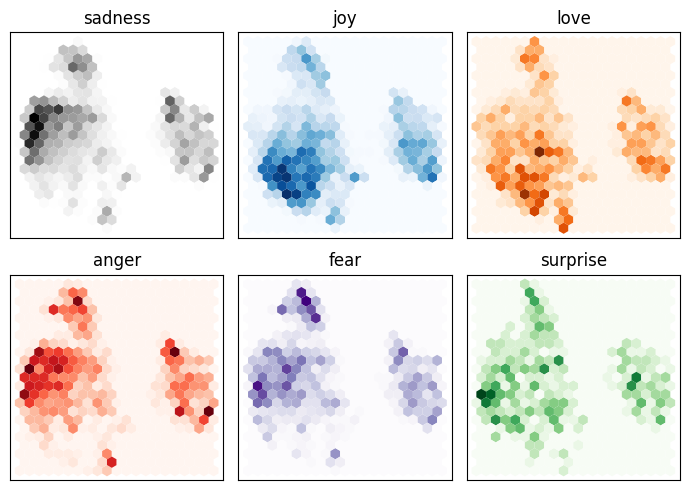

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)  # Adiciona o título com o nome da emoção
    axes[i].set_xticks([]), axes[i].set_yticks([])  # Remove os eixos

plt.tight_layout()  # Ajusta os subplots
plt.show()  # Exibe os gráficos

##  Training a simple classifier

### Usar Regressçao logistica

In [35]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.635

In [36]:
from sklearn.dummy import DummyClassifier

### Dummy Classifier

📌 Como Funciona o DummyClassifier?

Ele pode usar diferentes estratégias para fazer previsões, como:

1️⃣ "most_frequent" → Sempre prevê a classe mais comum no dataset.

2️⃣ "stratified" → Previsões seguem a distribuição real das classes.

3️⃣ "uniform" → Escolhe classes aleatoriamente com igual probabilidade.

4️⃣ "constant" → Sempre retorna uma classe específica definida pelo usuário.

📌 Quando Usar?

✔️ Baseline: Para comparar com modelos reais e verificar se estão aprendendo padrões.

✔️ Teste rápido: Para verificar se o pipeline de machine learning está funcionando.

✔️ Classes desbalanceadas: Pode ajudar a entender a distribuição das classes antes de usar um modelo mais sofisticado.

In [37]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

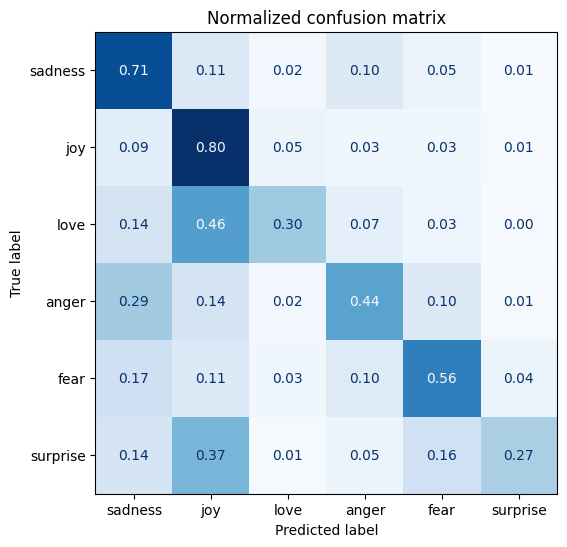

In [39]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

##  Fine-Tuning Transformers

### Loading a pretrained model

In [40]:
from transformers import AutoModelForSequenceClassification

In [41]:
num_labels = 6

In [42]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the performance metrics

In [43]:
from sklearn.metrics import accuracy_score, f1_score

In [52]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Training the model

In [53]:
from huggingface_hub import notebook_login

In [54]:
notebook_login()

In [55]:
from transformers import Trainer, TrainingArguments

In [56]:
batch_size = 64

# Define a frequência de logging baseada no tamanho do dataset
logging_steps = len(emotions_encoded["train"]) // batch_size

# Nome do modelo fine-tuned
model_name = f"{model_ckpt}-finetuned-emotion"

# Definição dos argumentos de treinamento
training_args = TrainingArguments(
    output_dir=model_name,          # Diretório para salvar o modelo
    num_train_epochs=2,             # Número de épocas de treinamento
    learning_rate=2e-5,             # Taxa de aprendizado
    per_device_train_batch_size=batch_size,  # Tamanho do batch no treino
    per_device_eval_batch_size=batch_size,   # Tamanho do batch na avaliação
    weight_decay=0.01,              # Decaimento de peso (regularização)
    eval_strategy="epoch",    # Avaliação a cada época
    disable_tqdm=False,             # Exibe barra de progresso
    logging_steps=logging_steps,    # Define os intervalos de logging
    push_to_hub=True,               # Envia o modelo para o Hugging Face Hub
    log_level="error"               # Define o nível de log para evitar poluição
)


Definição da Frequência de Logging

* Calcula a frequência com que os logs de treinamento serão gerados.

* `len(emotions_encoded["train"])`: Obtém o número total de exemplos no conjunto de treinamento.
* Divisão pelo `batch_size:` Isso significa que os logs serão registrados uma vez por época (passagem completa pelo dataset).

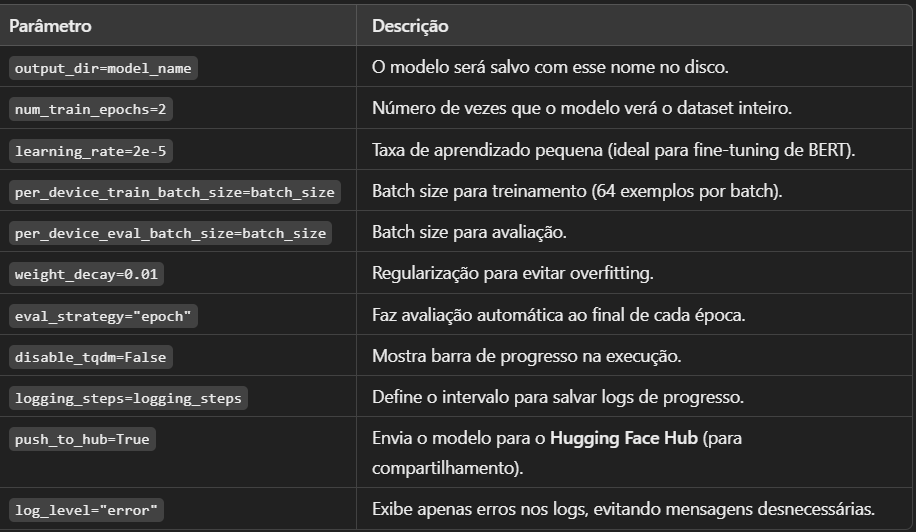

In [57]:
from transformers import Trainer

In [58]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

<ipython-input-58-56ca2ad043b4>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.206900,0.175262,0.928500,0.928890
2,0.134600,0.152693,0.934500,0.934638


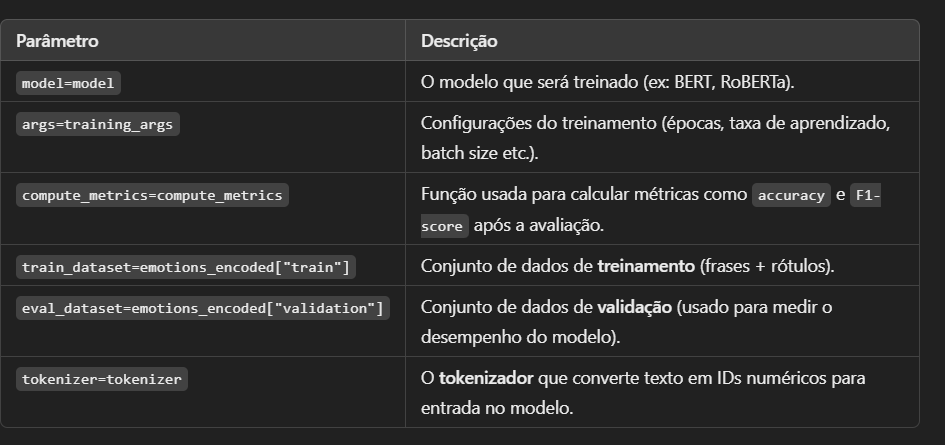

`trainer.train()`

* Carrega o modelo e os dados.
* Tokeniza e divide em batches (grupos de amostras para o treinamento).
* Calcula a perda (loss) e ajusta os pesos do modelo com base no erro.
* Faz avaliação periódica no eval_dataset para medir o desempenho.

In [60]:
preds_output = trainer.predict(emotions_encoded["validation"])

O Que Esse Código Faz?

* `trainer.predict(dataset)` faz previsões no conjunto de validação `(emotions_encoded["validation"])`.
* Retorna um objeto chamado PredictionOutput, que contém:

* `predictions`: Os valores de saída do modelo (logits).

* `label_ids`: Os rótulos verdadeiros (se disponíveis).

* `metrics`: As métricas calculadas (se definidas no Trainer).

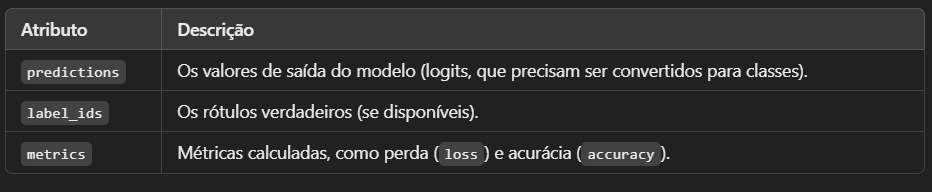

In [61]:
preds_output.metrics

{'test_loss': 0.15269288420677185,
 'test_accuracy': 0.9345,
 'test_f1': 0.934637592246108,
 'test_runtime': 3.6219,
 'test_samples_per_second': 552.202,
 'test_steps_per_second': 8.835}

In [62]:
y_preds = np.argmax(preds_output.predictions, axis=1)

O Que Esse Código Faz?


1. `preds_output.predictions` contém os logits, ou seja, os valores brutos da saída do modelo.
2. `np.argmax(..., axis=1)` pega o índice da classe com o maior valor (maior probabilidade).
3. O resultado `y_preds` contém os rótulos previstos (0, 1, 2... dependendo da classificação).


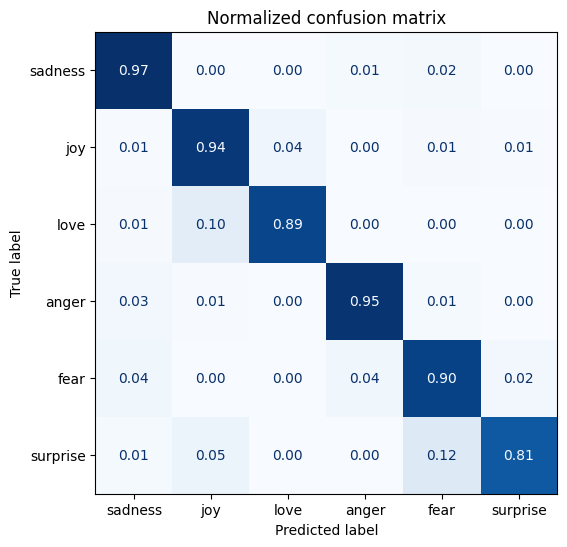

In [63]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Análise de erro

In [64]:
from torch.nn.functional import cross_entropy

In [65]:
def forward_pass_with_label(batch):
    # Move todos os tensores de entrada para o mesmo dispositivo do modelo
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)  # Faz a predição sem calcular gradientes
        pred_label = torch.argmax(output.logits, axis=-1)  # Obtém a classe prevista
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")  # Calcula a perda

    # Move os resultados para a CPU e converte para numpy
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

 O Que Esse Código Faz?

A função `forward_pass_with_label(batch)` recebe um lote de dados (batch) e faz o seguinte:

Move os dados para o mesmo dispositivo do modelo (CPU/GPU).

Faz uma previsão usando o modelo (sem calcular gradientes, pois usa `torch.no_grad())`.

Obtém os rótulos previstos (classe com maior probabilidade).

Calcula a perda `(loss)` usando `cross_entropy`.

Move os resultados para a CPU para facilitar o armazenamento ou análise posterior.

In [72]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [73]:
 def label_int2str(row):
     return emotions["train"].features["label"].int2str(row)
 df["label_name"] = df["label"].apply(label_int2str)
 df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Converter o dataset de volta para Pytorch tensors

In [67]:
# Converter para Pytorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

### Computar o valores erros

In [68]:
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Aplica a função forward_pass_with_label a todo o conjunto de validação (validation), processando os dados em lotes (batch_size=16).

Explicação Detalhada

* `map(forward_pass_with_label, batched=True, batch_size=16)` → Aplica `forward_pass_with_label` a cada lote de 16 amostras.
* A função retorna loss e predicted_label, que serão adicionados automaticamente ao dataset.
* O dataset `emotions_encoded["validation"]` é atualizado com essas novas colunas.

O Que Esse Código Faz na Prática?

* O dataset validation tinha apenas textos e rótulos originais.
* Agora, ele ganha duas novas colunas:
* `"loss"` → A perda do modelo para cada amostra.
* `"predicted_label"` → O rótulo previsto pelo modelo.


In [69]:
# Converte o dataset para o formato Pandas
emotions_encoded.set_format("pandas")

# Seleciona as colunas relevantes
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]

✅ O que acontece aqui?

`set_format("pandas")` → Converte o conjunto de dados Hugging Face para um DataFrame Pandas.

* `cols = ["text", "label", "predicted_label", "loss"]` → Define quais colunas serão extraídas.
* `df_test = emotions_encoded["validation"][:][cols]` → Cria um DataFrame apenas com essas colunas.

In [74]:
# Converte os rótulos de números inteiros para nomes de classes
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

✅ O que acontece aqui?

* O dataset armazena os rótulos como números inteiros (0, 1, 2...), que representam emoções.

* `label_int2str` é uma função que converte esses números para nomes legíveis ("alegria", "raiva", "tristeza", etc.).

In [75]:
 df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.190666
1963,i called myself pro life and voted for perry w...,joy,sadness,7.172409
1509,i guess this is a memoir so it feels like that...,joy,fear,6.855099
1801,i feel that he was being overshadowed by the s...,love,sadness,6.506255
1870,i guess i feel betrayed because i admired him ...,joy,sadness,6.377006
882,i feel badly about reneging on my commitment t...,love,sadness,6.118027
318,i felt ashamed of these feelings and was scare...,fear,sadness,6.085461
1111,im lazy my characters fall into categories of ...,joy,fear,5.631234
1840,id let you kill it now but as a matter of fact...,joy,fear,4.832496
1581,i feel stronger clearer but a little annoyed n...,anger,joy,4.411000


 Ordena o DataFrame df_test pela coluna `"loss"` em ordem decrescente e exibe as 10 amostras com maior erro do modelo.


Explicação Detalhada

* `sort_values("loss", ascending=False)` → Ordena o DataFrame de acordo com a perda (loss), do maior para o menor.

`.head(10)` → Pega apenas as 10 amostras com maior erro (maior loss).

Por Que Isso é Útil?

🔹 Ajuda a identificar frases onde o modelo teve mais dificuldade.

🔹 Permite entender padrões nos erros (ex.: confusões entre emoções similares).

🔹 Pode ser útil para refinamento do modelo, re-treinamento ou ajustes nos dados.

In [76]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.003269
720,i believe you have to truly regret feel remors...,sadness,sadness,0.003277
1810,i feel like i m going to become sleep deprived...,sadness,sadness,0.003320
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.003321
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.003325
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.003347
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.003385
1024,i haven t been here for even a year yet i can ...,sadness,sadness,0.003406
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.003415
1310,i feel like an ungrateful asshole,sadness,sadness,0.003448


## Salvar e compartilhar o modelo

In [77]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1742495385.6a62d843826a.1742.1:   0%|          | 0.00/6.87k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Hitoshiiii/distilbert-base-uncased-finetuned-emotion/commit/93aea72986e6aec0026bb63ecbf6bb327fdad40e', commit_message='Training completed!', commit_description='', oid='93aea72986e6aec0026bb63ecbf6bb327fdad40e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Hitoshiiii/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='Hitoshiiii/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [84]:
from transformers import pipeline
 # Change `transformersbook` to your Hub username
model_id = "Hitoshiiii/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [85]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


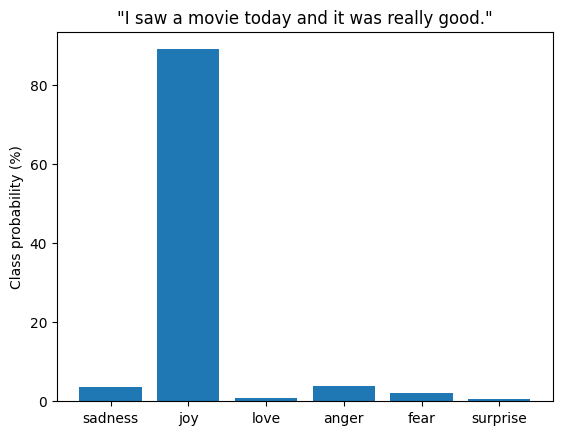

In [86]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

In [94]:
def analyze_tweets(classifier, labels):
    while True:
        custom_tweet = input("\nDigite uma frase para análise (ou 'finalizar' para sair): ")
        if custom_tweet.lower() in ["finalizar", "sair"]:
            print("Finalizando o programa...")
            break

        # Faz a predição
        preds = classifier(custom_tweet, return_all_scores=True)
        preds_df = pd.DataFrame(preds[0])

        # Exibe o gráfico de barras
        plt.figure(figsize=(6, 4))  # Garante que o gráfico tenha um tamanho adequado
        plt.bar(labels, 100 * preds_df["score"], color='C0')
        plt.title(f'"{custom_tweet}"')
        plt.ylabel("Class probability (%)")
        plt.ylim(0, 100)  # Define o limite do eixo Y para melhor visualização
        plt.show(block=False)  # Impede que o gráfico trave a execução

        # Aguarda um pouco para exibir o gráfico e não bloquear o loop
        plt.pause(0.5)



Digite uma frase para análise (ou 'finalizar' para sair): I saw a movie today and it was really good


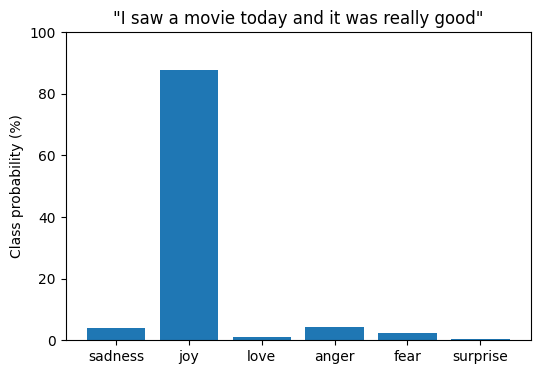


Digite uma frase para análise (ou 'finalizar' para sair): I just got a promotion at work! I'm so happy!


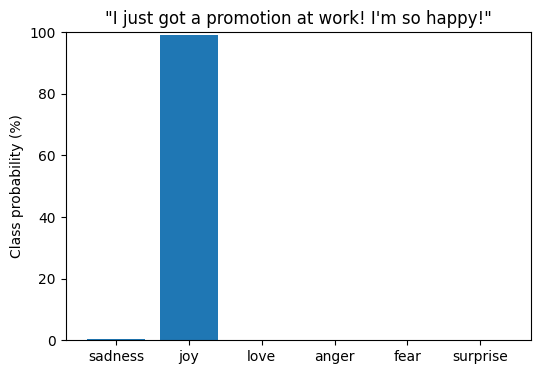


Digite uma frase para análise (ou 'finalizar' para sair): This is so frustrating! Why do things never work?


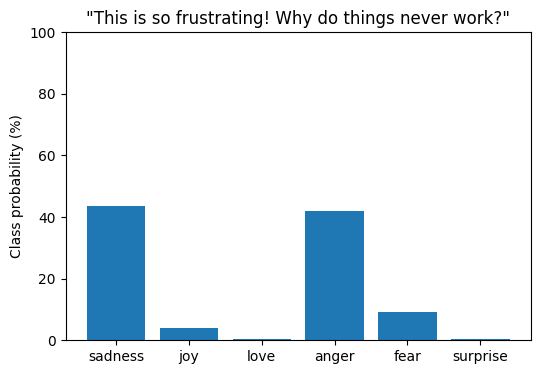


Digite uma frase para análise (ou 'finalizar' para sair): I feel really lonely today..


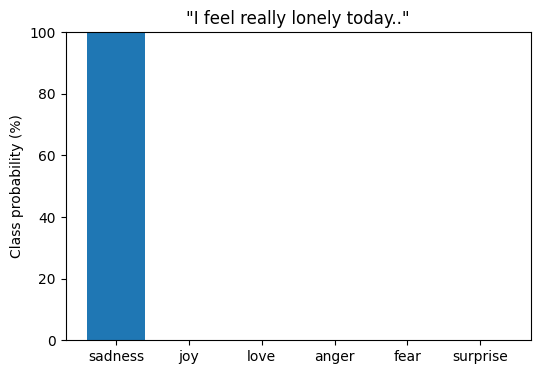


Digite uma frase para análise (ou 'finalizar' para sair): sair


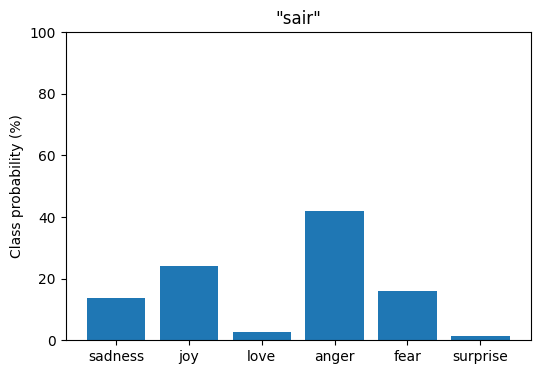


Digite uma frase para análise (ou 'finalizar' para sair): finalizar
Finalizando o programa...


In [95]:
analyze_tweets(classifier, labels)

In [97]:
!zip -r /content/meu_projeto.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.03.19/ (stored 0%)
  adding: content/.config/logs/2025.03.19/13.33.44.746330.log (deflated 92%)
  adding: content/.config/logs/2025.03.19/13.34.27.800724.log (deflated 56%)
  adding: content/.config/logs/2025.03.19/13.34.05.875297.log (deflated 58%)
  adding: content/.config/logs/2025.03.19/13.34.17.062166.log (deflated 58%)
  adding: content/.config/logs/2025.03.19/13.34.27.006088.log (deflated 57%)
  adding: content/.config/logs/2025.03.19/13.34.15.605453.log (deflated 87%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/con

In [98]:
from google.colab import files
files.download("/content/meu_projeto.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>